In [12]:
import numpy as np
from scipy import stats, special, optimize

class VASH:
    def __init__(self, max_components=10, max_iter=1000, tol=1e-4):
        self.max_components = max_components
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = None
        self.beta = None
        self.pi = None
    
    def fit(self, log_variances, df, betahat=None, unimodal='auto', singlecomp=False):
        self.log_variances = log_variances
        self.df = df
        self.betahat = betahat
        self.unimodal = unimodal
        self.singlecomp = singlecomp
        
        if singlecomp:
            self._fit_single_component()
        else:
            self._fit_multiple_components()
        
        return self
    
    def _fit_single_component(self):
        alpha, beta = self.est_singlecomp_mm(np.exp(self.log_variances/2), self.df)
        self.alpha = np.array([alpha])
        self.beta = np.array([beta])
        self.pi = np.array([1.0])
    
    def _fit_multiple_components(self):
        best_bic = np.inf
        best_model = None
        
        for n_components in range(1, self.max_components + 1):
            model = self._fit_model(n_components)
            if model is not None:
                bic = self._compute_bic(model)
                
                if bic < best_bic:
                    best_bic = bic
                    best_model = model
                else:
                    break  # BIC开始增加，停止添加组件
        
        if best_model is not None:
            self.alpha, self.beta, self.pi = best_model
        else:
            # 如果所有模型都失败，退回到单组分模型
            self._fit_single_component()
    
    def _fit_model(self, n_components):
        # 初始化参数
        alpha = np.linspace(1, 10, n_components)
        beta = np.ones(n_components)
        pi = np.ones(n_components) / n_components
        
        for _ in range(self.max_iter):
            old_params = np.concatenate([alpha, beta, pi])
            
            # E步
            resp = self._e_step(alpha, beta, pi)
            
            # M步
            alpha, beta, pi = self._m_step(resp, alpha, beta)
            
            # 应用单峰约束
            if self.unimodal in ['variance', 'auto']:
                alpha, beta = self._apply_unimodal_constraint(alpha, beta, 'variance')
            if self.unimodal in ['precision', 'auto']:
                alpha, beta = self._apply_unimodal_constraint(alpha, beta, 'precision')
            
            # 检查收敛
            new_params = np.concatenate([alpha, beta, pi])
            if np.max(np.abs(new_params - old_params)) < self.tol:
                return alpha, beta, pi
        
        return None  # 如果没有收敛，返回None
    
    def _e_step(self, alpha, beta, pi):
        n = len(self.log_variances)
        k = len(alpha)
        resp = np.zeros((n, k))
        
        for j in range(k):
            resp[:, j] = pi[j] * stats.invgamma.pdf(np.exp(self.log_variances), alpha[j], scale=beta[j])
        
        resp /= resp.sum(axis=1, keepdims=True)
        return resp
    
    def _m_step(self, resp, alpha, beta):
        n = len(self.log_variances)
        k = resp.shape[1]
        
        pi = resp.sum(axis=0) / n
        new_alpha = np.zeros(k)
        new_beta = np.zeros(k)
        
        for j in range(k):
            def obj(params):
                a, b = params
                return -np.sum(resp[:, j] * stats.invgamma.logpdf(np.exp(self.log_variances), a, scale=b))
            
            res = optimize.minimize(obj, [alpha[j], beta[j]], method='L-BFGS-B', bounds=[(1e-5, None), (1e-5, None)])
            new_alpha[j], new_beta[j] = res.x
        
        return new_alpha, new_beta, pi
    
    def _apply_unimodal_constraint(self, alpha, beta, mode):
        if mode == 'variance':
            c = beta / (alpha + 1)
            order = np.argsort(c)
            alpha = alpha[order]
            beta = c[order] * (alpha + 1)
        elif mode == 'precision':
            c = beta / (alpha - 1)
            order = np.argsort(c)[::-1]
            alpha = alpha[order]
            beta = c[order] * (alpha - 1)
        return alpha, beta
    
    def _compute_bic(self, model):
        alpha, beta, pi = model
        n = len(self.log_variances)
        k = len(alpha)
        log_likelihood = self.loglike(np.exp(self.log_variances/2), self.df, pi, alpha, beta)
        num_params = 3 * k - 1  # k个alpha, k个beta, k-1个自由的pi
        return -2 * log_likelihood + num_params * np.log(n)
    
    def posterior_mean(self):
        resp = self._e_step(self.alpha, self.beta, self.pi)
        return np.log(np.sum(resp * (self.beta / (self.alpha - 1))[np.newaxis, :], axis=1))
    
    def moderated_t_test(self):
        if self.betahat is None:
            raise ValueError("betahat is required for moderated t-test")
        
        post_var = np.exp(self.posterior_mean())
        t_stat = self.betahat / np.sqrt(post_var)
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=self.df))
        
        return p_values
    
    @staticmethod
    def loglike(sehat, df, pi, alpha, beta):
        k = len(pi)
        n = len(sehat)
        
        pimat = np.outer(np.ones(n), pi) * np.exp(
            df/2 * np.log(df/2) - special.gammaln(df/2) +
            (df/2 - 1) * np.outer(2*np.log(sehat), np.ones(k)) +
            np.outer(np.ones(n), alpha*np.log(beta) - special.gammaln(alpha) + special.gammaln(alpha + df/2)) -
            np.outer(np.ones(n), alpha + df/2) * np.log(np.outer(df/2 * sehat**2, beta) + 1)
        )
        
        return np.sum(np.log(np.sum(pimat, axis=1)))
    
    @staticmethod
    def est_singlecomp_mm(sehat, df):
        n = len(sehat)
        e = 2*np.log(sehat) - special.digamma(df/2) + np.log(df/2)
        ehat = np.mean(e)
        
        def solve_trigamma(x):
            if x > 1e7:
                return 1/np.sqrt(x)
            elif x < 1e-6:
                return 1/x
            else:
                y_old = 0.5 + 1/x
                while True:
                    delta = special.trigamma(y_old) * (1 - special.trigamma(y_old)/x) / special.polygamma(2, y_old)
                    y_new = y_old + delta
                    if -delta/y_new <= 1e-8:
                        return y_new
                    y_old = y_new
        
        a = solve_trigamma(np.mean((e-ehat)**2 * n/(n-1) - special.trigamma(df/2)))
        b = a * np.exp(ehat + special.digamma(df/2) - np.log(df/2))
        
        return a, b

# 主程序
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
from scipy import stats, optimize, special
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/processed_151673_filtered.h5ad")

# 计算每个基因的方差（适用于稀疏矩阵）
def sparse_var(X, axis=0):
    mean = np.array(X.mean(axis=axis)).flatten()
    squared_diff = X.copy()
    squared_diff.data **= 2
    var = squared_diff.mean(axis=axis).A1 - mean**2
    return var

gene_variances = sparse_var(adata.X)

# 计算方差的对数，添加小常数避免log(0)
log_gene_variances = np.log(gene_variances + 1e-8)

# 由于没有直接的 degrees_of_freedom，我们可以使用一个固定值或基于细胞数量的估计
df = adata.n_obs - 1  # 使用细胞数量减1作为自由度

# 拟合VASH模型
vash = VASH(max_components=10)
vash.fit(log_gene_variances, df, unimodal='auto')

# 获取后验均值（在对数空间）
posterior_means_log = vash.posterior_mean()

# 将后验均值添加到AnnData对象
adata.var['vash_posterior_mean_log'] = posterior_means_log

# 使用拟合的模型进行模拟，并限制最大值和最小值
def simulate_from_vash(vash, n_genes, min_log_variance, max_log_variance):
    component_choices = np.random.choice(len(vash.pi), size=n_genes, p=vash.pi)
    simulated_log_variances = np.array([
        np.log(stats.invgamma.rvs(vash.alpha[i], scale=vash.beta[i]))
        for i in component_choices
    ])
    
    # 截断模拟的对数方差，使其在观察到的最小和最大对数方差之间
    simulated_log_variances = np.clip(simulated_log_variances, min_log_variance, max_log_variance)
    
    return simulated_log_variances

# 计算观察到的最小和最大对数方差
min_observed_log_variance = np.min(log_gene_variances)
max_observed_log_variance = np.max(log_gene_variances)

# 模拟与原始数据相同数量的基因的对数方差
n_genes = adata.n_vars
simulated_log_variances = simulate_from_vash(vash, n_genes, min_observed_log_variance, max_observed_log_variance)

# 计算方差相关性
def variance_correlation(log_variances1, log_variances2):
    return np.corrcoef(log_variances1, log_variances2)[0, 1]

# 计算原始对数方差和模拟对数方差之间的相关性
correlation = variance_correlation(log_gene_variances, simulated_log_variances)
print(f"Correlation between original and simulated log variances: {correlation}")

# 可视化原始对数方差和模拟对数方差的分布
plt.figure(figsize=(10, 6))
sns.histplot(log_gene_variances, kde=True, label='Original Log Variances')
sns.histplot(simulated_log_variances, kde=True, label='Simulated Log Variances')
plt.xlabel('Log Variance')
plt.ylabel('Density')
plt.title('Distribution of Original vs Simulated Log Variances')
plt.legend()
plt.show()

/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/3v/3zvgxtgj0c18q0snf15v3prc0000gn/T/ipykernel_71253/1545875665.py:88: RuntimeWarning: overflow encountered in exp
  resp[:, j] = pi[j] * stats.invgamma.pdf(np.exp(self.log_variances), alpha[j], scale=beta[j])
/var/folders/3v/3zvgxtgj0c18q0snf15v3prc0000gn/T/ipykernel_71253/1545875665.py:90: RuntimeWarning: invalid value encountered in divide
  resp /= resp.sum(axis=1, keepdims=True)
/var/folders/3v/3zvgxtgj0c18q0snf15v3prc0000gn/T/ipykernel_71253/1545875665.py:104: RuntimeWarning: overflow encountered in exp
  return -np.sum(resp[:, j] * stats.invgamma.logpdf(np.exp(self.log_variances), a, scale=b))
/var/folders/3v/3zvgxtgj0c18q0snf15v3prc0000gn/T/ipykernel_71253/1545875665.py:118: RuntimeWarning: divide by zero encountered in divide
  c = b

AttributeError: module 'scipy.special' has no attribute 'trigamma'

/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Best number of components: 10


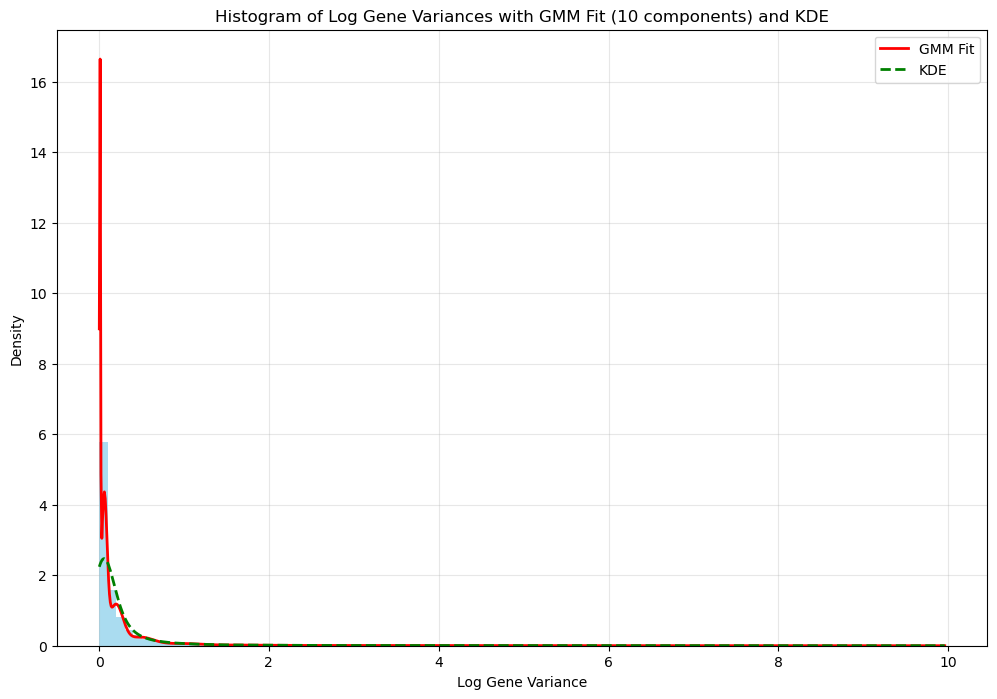

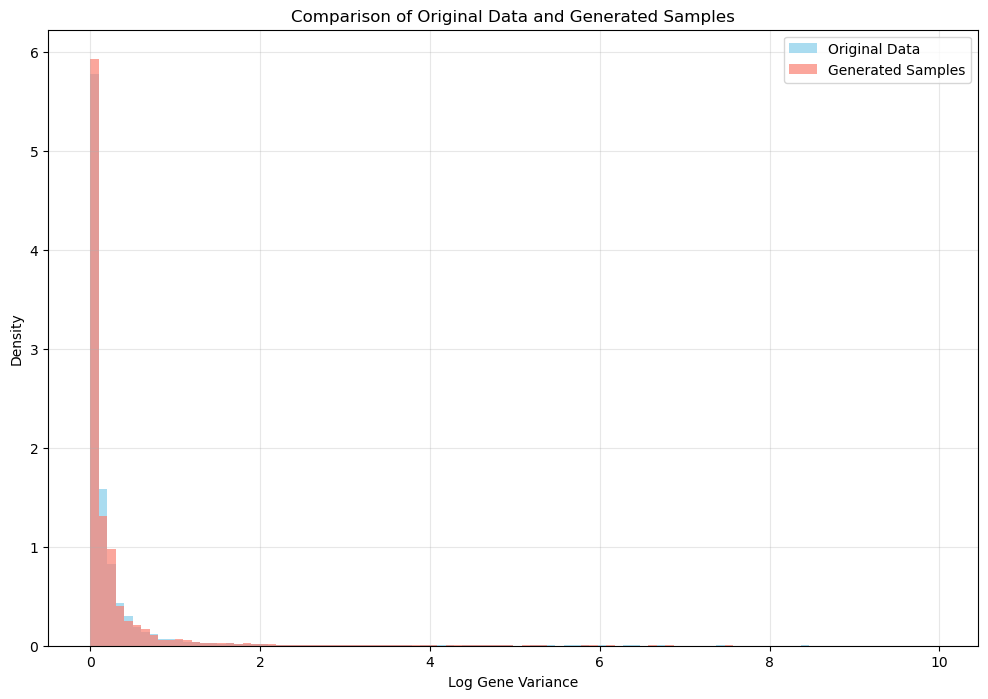

Original data - Mean: 0.277072, Std: 0.762120
Generated samples - Mean: 0.281303, Std: 0.760655

Quantiles comparison:
1.0% - Original: 0.002785, Generated: 0.002785, Diff: 0.000000
5.0% - Original: 0.004172, Generated: 0.003104, Diff: 0.001068
10.0% - Original: 0.006383, Generated: 0.007112, Diff: 0.000729
25.0% - Original: 0.018775, Generated: 0.016855, Diff: 0.001920
50.0% - Original: 0.074367, Generated: 0.074710, Diff: 0.000344
75.0% - Original: 0.219644, Generated: 0.227054, Diff: 0.007410
90.0% - Original: 0.555625, Generated: 0.583898, Diff: 0.028272
95.0% - Original: 1.057160, Generated: 1.106134, Diff: 0.048974
99.0% - Original: 4.099903, Generated: 4.193161, Diff: 0.093258

Correlation between original and generated log variances: 0.999451


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split

# 假设 log_gene_variances 已经计算好了
# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/processed_151673_filtered.h5ad")

# 计算每个基因的方差（适用于稀疏矩阵）
def sparse_var(X, axis=0):
    mean = np.array(X.mean(axis=axis)).flatten()
    squared_diff = X.copy()
    squared_diff.data **= 2
    var = squared_diff.mean(axis=axis).A1 - mean**2
    return var

gene_variances = sparse_var(adata.X)

# 计算方差的对数，添加小常数避免log(0)
gene_variances = gene_variances

# 取小于10的方差
gene_variances = gene_variances[gene_variances < 10]
# 将数据重塑为二维数组
X = log_gene_variances.reshape(-1, 1)

# 分割数据为训练集和测试集
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# 使用BIC准则选择最佳的组件数量
n_components_range = range(1, 11)
bic = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)
    bic.append(gmm.bic(X_train))

best_n_components = n_components_range[np.argmin(bic)]

# 使用最佳组件数量拟合GMM
best_gmm = GaussianMixture(n_components=best_n_components, random_state=42)
best_gmm.fit(X_train)

print(f"Best number of components: {best_n_components}")

# 在原数据范围内生成更密集的点进行预测
x = np.linspace(np.min(log_gene_variances), np.max(log_gene_variances), 1000).reshape(-1, 1)
y = np.exp(best_gmm.score_samples(x))

# 计算原始数据的核密度估计
kde = gaussian_kde(log_gene_variances)

# 绘制直方图、GMM拟合曲线和KDE
plt.figure(figsize=(12, 8))
plt.hist(log_gene_variances, bins=100, density=True, alpha=0.7, color='skyblue')
plt.plot(x, y, 'r-', lw=2, label='GMM Fit')
plt.plot(x, kde(x.ravel()), 'g--', lw=2, label='KDE')
plt.xlabel('Log Gene Variance')
plt.ylabel('Density')
plt.title(f'Histogram of Log Gene Variances with GMM Fit ({best_n_components} components) and KDE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 生成新样本
def generate_truncated_samples(n_samples):
    samples = best_gmm.sample(n_samples)[0].ravel()
    return np.clip(samples, np.min(log_gene_variances), np.max(log_gene_variances))

# 修改生成样本的数量以匹配原始数据
n_samples = len(log_gene_variances)

# 生成新样本
def generate_truncated_samples(n_samples):
    samples = best_gmm.sample(n_samples)[0].ravel()
    return np.clip(samples, np.min(log_gene_variances), np.max(log_gene_variances))

# 生成与原始数据相同数量的新样本
new_samples = generate_truncated_samples(n_samples)

# 绘制新样本的直方图与原始数据对比
plt.figure(figsize=(12, 8))
plt.hist(log_gene_variances, bins=100, density=True, alpha=0.7, color='skyblue', label='Original Data')
plt.hist(new_samples, bins=100, density=True, alpha=0.7, color='salmon', label='Generated Samples')
plt.xlabel('Log Gene Variance')
plt.ylabel('Density')
plt.title('Comparison of Original Data and Generated Samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 计算并打印一些统计量
print(f"Original data - Mean: {np.mean(log_gene_variances):.6f}, Std: {np.std(log_gene_variances):.6f}")
print(f"Generated samples - Mean: {np.mean(new_samples):.6f}, Std: {np.std(new_samples):.6f}")

# 计算分位数
quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
original_quantiles = np.quantile(log_gene_variances, quantiles)
generated_quantiles = np.quantile(new_samples, quantiles)

print("\nQuantiles comparison:")
for q, orig, gen in zip(quantiles, original_quantiles, generated_quantiles):
    print(f"{q*100}% - Original: {orig:.6f}, Generated: {gen:.6f}, Diff: {abs(orig-gen):.6f}")

def variance_correlation(log_variances1, log_variances2):
    return np.corrcoef(log_variances1, log_variances2)[0, 1]

# 计算原始对数方差和模拟对数方差之间的相关性
correlation = variance_correlation(np.sort(log_gene_variances), np.sort(new_samples))
print(f"\nCorrelation between original and generated log variances: {correlation:.6f}")

In [9]:
# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/processed_151673_filtered.h5ad")

# 计算每个基因的方差（适用于稀疏矩阵）
def sparse_var(X, axis=0):
    mean = np.array(X.mean(axis=axis)).flatten()
    squared_diff = X.copy()
    squared_diff.data **= 2
    var = squared_diff.mean(axis=axis).A1 - mean**2
    return var

gene_variances = sparse_var(adata.X)

# 计算方差的对数，添加小常数避免log(0)
log_gene_variances = np.log(gene_variances + 1e-8)

# 由于没有直接的 degrees_of_freedom，我们可以使用一个固定值或基于细胞数量的估计
df = adata.n_obs - 1  # 使用细胞数量减1作为自由度

# 拟合VASH模型
vash = VASH(max_components=10)
vash.fit(log_gene_variances, df, unimodal='auto')

# 获取后验均值（在对数空间）
posterior_means_log = vash.posterior_mean()

# 将后验均值添加到AnnData对象
adata.var['vash_posterior_mean_log'] = posterior_means_log

# 使用拟合的模型进行模拟，并限制最大值和最小值
def simulate_from_vash(vash, n_genes, min_log_variance, max_log_variance):
    component_choices = np.random.choice(len(vash.pi), size=n_genes, p=vash.pi)
    simulated_log_variances = np.array([
        np.log(stats.invgamma.rvs(vash.alpha[i], scale=vash.beta[i]))
        for i in component_choices
    ])
    
    # 截断模拟的对数方差，使其在观察到的最小和最大对数方差之间
    simulated_log_variances = np.clip(simulated_log_variances, min_log_variance, max_log_variance)
    
    return simulated_log_variances

# 计算观察到的最小和最大对数方差
min_observed_log_variance = np.min(log_gene_variances)
max_observed_log_variance = np.max(log_gene_variances)

# 模拟与原始数据相同数量的基因的对数方差
n_genes = adata.n_vars
simulated_log_variances = simulate_from_vash(vash, n_genes, min_observed_log_variance, max_observed_log_variance)

# 计算方差相关性
def variance_correlation(log_variances1, log_variances2):
    return np.corrcoef(log_variances1, log_variances2)[0, 1]

# 计算原始对数方差和模拟对数方差之间的相关性
correlation = variance_correlation(log_gene_variances, simulated_log_variances)
print(f"Correlation between original and simulated log variances: {correlation}")

# 可视化原始对数方差和模拟对数方差的分布
plt.figure(figsize=(10, 6))
sns.histplot(log_gene_variances, kde=True, label='Original Log Variances')
sns.histplot(simulated_log_variances, kde=True, label='Simulated Log Variances')
plt.xlabel('Log Variance')
plt.ylabel('Density')
plt.title('Distribution of Original vs Simulated Log Variances')
plt.legend()
plt.show()

/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AttributeError: 'VASH' object has no attribute 'sehat'

In [4]:
variance_correlation(gene_variances, simulated_variances)

-0.00019753228253230497

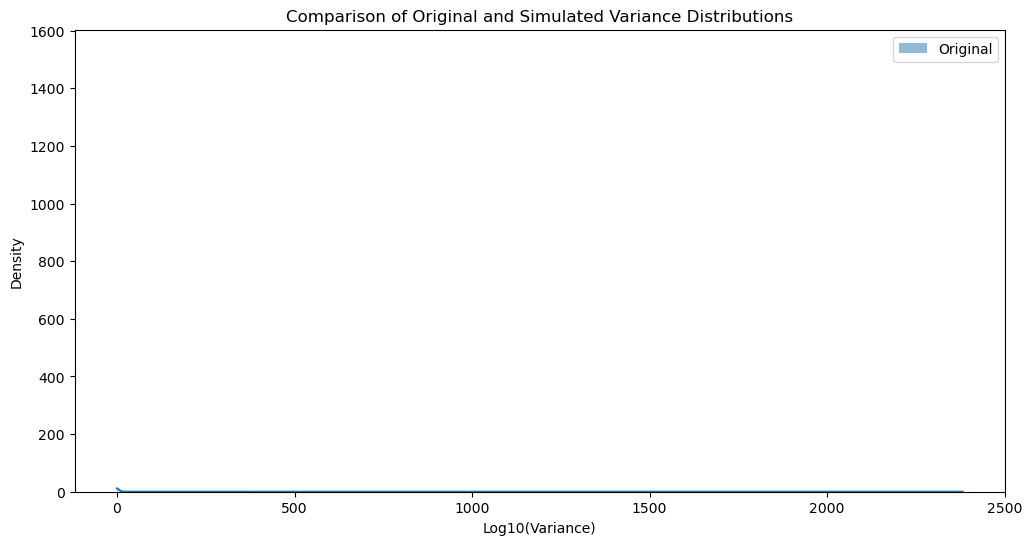

In [5]:
# 可视化原始方差和模拟方差的分布
plt.figure(figsize=(12, 6))
sns.histplot(gene_variances, kde=True, label='Original', alpha=0.5)

plt.xlabel('Log10(Variance)')
plt.ylabel('Density')
plt.title('Comparison of Original and Simulated Variance Distributions')
plt.legend()
plt.show()

<Axes: ylabel='Count'>

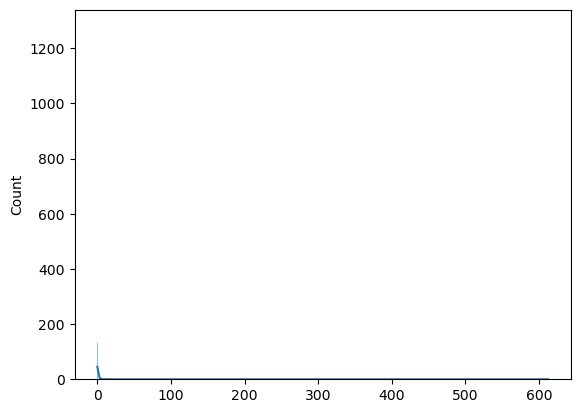

In [6]:
sns.histplot(simulated_variances, kde=True, label='Simulated', alpha=0.5)

In [ ]:
import numpy as np
import pandas as pd
import anndata
import scipy.sparse as sp
import scanpy as sc
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy import stats, optimize

# Assuming the following functions are already defined in your script:
# - simulate_gene_average_expression
# - fit_marginal_model_with_simulated_means_and_variances

class variation_sim:
    # variation_sim class definition as provided earlier
    
    def __init__(self, max_components=10, max_iter=1000, tol=1e-4):
        self.max_components = max_components
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = None
        self.beta = None
        self.pi = None

    # Rest of the class methods (fit, _fit_single_component, _fit_multiple_components, etc.)
    # These methods remain unchanged from the previous implementation

def run_simulation_tissue(adata):
    # Ensure unique gene and cell names (obs and var names)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()

    # Calculate quality control metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)

    # List of all gene names
    all_genes = adata.var_names.tolist()
    print(adata)

    # Simulate gene expression means
    simulated_means = simulate_gene_average_expression(adata)
    print(f"Number of simulated means: {len(simulated_means.keys())}")

    # Check if the data matrix is sparse
    if sp.issparse(adata.X):
        X = adata.X.toarray()  # Convert sparse matrix to dense
    else:
        X = adata.X

    # Extract the standard error (sehat) and degrees of freedom (df) from the original data
    sehat = np.std(X, axis=0)  # Using standard deviation as sehat (standard error)
    df = X.shape[0] - 1  # Degrees of freedom based on the number of cells

    # Fit the variation model to the standard errors
    varsim = variation_sim()
    varsim.fit(sehat, df)

    # Generate new variances based on the fitted model
    simulated_variances = varsim.posterior_mean()

    # Sort the simulated variances and the original variances, and assign them accordingly
    original_variances = np.var(X, axis=0)
    sorted_indices = np.argsort(original_variances)  # Get the indices that would sort the original variances
    sorted_simulated_variances = np.sort(simulated_variances)  # Sort the simulated variances

    # Create a dictionary that maps gene names to their sorted simulated variances
    simulated_variances_dict = {all_genes[idx]: sorted_simulated_variances[i] for i, idx in enumerate(sorted_indices)}

    # Fit marginal model with simulated means and variances
    model_params = fit_marginal_model_with_simulated_means_and_variances(
        adata, 
        simulated_means, 
        simulated_variances_dict,  # Use the sorted simulated variances
        min_nonzero_num=2, 
        maxiter=500, 
        n_jobs=10
    )

    return model_params

# Assuming the following function is defined:
# - srtsim_remain_simulate_count
# which is a function that simulates counts based on the SimSRT object and model.

class SimSRT:
    def __init__(self, adata, model_params):
        # Save the reference counts and metadata (obs)
        self.refCounts = adata.to_df()  # DataFrame of counts
        self.refcolData = adata.obs.copy()  # Copy of the observation metadata
        self.simcolData = None  # To store simulated colData
        self.EstParam = [model_params]  # List to store estimated model parameters
        self.simCounts = None  # To store simulated counts

# Load the data
adata = sc.read_h5ad("/mnt/volume1/2023SRTP/library/cyr/Sample_data_151675.h5ad")

# Run the simulation to get model parameters
model_params = run_simulation_tissue(adata)

# Initialize the SimSRT object with the reference dataset and model parameters
simsrt = SimSRT(adata, model_params)

# Simulate counts (assumes srtsim_remain_simulate_count is defined)
simulated_simsrt = srtsim_remain_simulate_count(simsrt, adata, num_cores=8, verbose=True)

# Extract the simulated counts
simulated_counts = simulated_simsrt.simCounts

# Check if the simulated counts have the same shape as the original data
if simulated_counts.shape != adata.shape:
    print(f"Warning: simulated_counts shape {simulated_counts.shape} does not match adata shape {adata.shape}")
    # Transpose if the dimensions are swapped
    if simulated_counts.shape == (adata.shape[1], adata.shape[0]):
        simulated_counts = simulated_counts.T  
    else:
        raise ValueError("Cannot adjust simulated_counts shape to match adata shape")

# Create a new AnnData object with the simulated counts and copy over metadata
simulated_adata = anndata.AnnData(
    X=simulated_counts,
    obs=adata.obs.copy(),  # Copy the original observation metadata
    var=adata.var.copy(),  # Copy the original variable metadata
    obsm={'spatial': adata.obsm['spatial']}  # Copy the spatial coordinates
)

# Add QC metrics to the simulated data
simulated_adata.obs['total_counts'] = simulated_adata.X.sum(axis=1)
simulated_adata.obs['n_genes'] = (simulated_adata.X > 0).sum(axis=1)

# Return the simulated AnnData object for further analysis
simulated_adata

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
from scipy import stats, optimize, special
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/processed_151673_filtered.h5ad")

# 计算每个基因的方差（适用于稀疏矩阵）
def sparse_var(X, axis=0):
    mean = np.array(X.mean(axis=axis)).flatten()
    squared_diff = X.copy()
    squared_diff.data **= 2
    var = squared_diff.mean(axis=axis).A1 - mean**2
    return var

gene_variances = sparse_var(adata.X)

/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


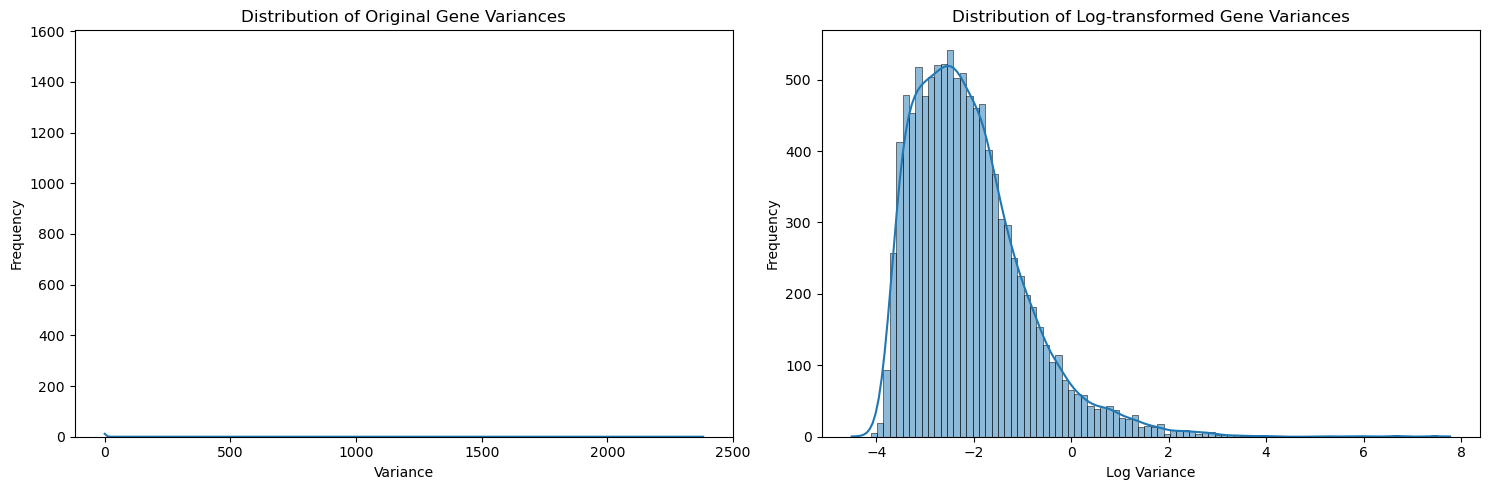

Original Variances:
Min: 0.011014122515916824
Max: 2381.0673828125
Mean: 1.2564479112625122
Median: 0.10179155319929123

Log-transformed Variances:
Min: -4.508575916290283
Max: 7.775304317474365
Mean: -2.0935637950897217
Median: -2.2848281860351562

Invalid Values:
NaNs in original: 0
Infs in original: 0
NaNs in log-transformed: 0
Infs in log-transformed: 0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

adata = sc.read("/Users/chen_yiru/Desktop/simulation/Sample_data_151675.h5ad")

# 计算每个基因的方差（适用于稀疏矩阵）
def sparse_var(X, axis=0):
    mean = np.array(X.mean(axis=axis)).flatten()
    squared_diff = X.copy()
    squared_diff.data **= 2
    var = squared_diff.mean(axis=axis).A1 - mean**2
    return var

gene_variances = sparse_var(adata.X)

# 创建一个新的图形，包含两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 绘制原始方差的分布
sns.histplot(gene_variances, ax=ax1, kde=True)
ax1.set_title('Distribution of Original Gene Variances')
ax1.set_xlabel('Variance')
ax1.set_ylabel('Frequency')

# 对数变换方差
log_gene_variances = np.log(gene_variances + 1e-8)  # 添加小常数以避免log(0)

# 绘制对数变换后方差的分布
sns.histplot(log_gene_variances, ax=ax2, kde=True)
ax2.set_title('Distribution of Log-transformed Gene Variances')
ax2.set_xlabel('Log Variance')
ax2.set_ylabel('Frequency')

# 调整布局并显示图形
plt.tight_layout()
plt.show()

# 打印一些基本统计信息
print("Original Variances:")
print(f"Min: {gene_variances.min()}")
print(f"Max: {gene_variances.max()}")
print(f"Mean: {gene_variances.mean()}")
print(f"Median: {np.median(gene_variances)}")

print("\nLog-transformed Variances:")
print(f"Min: {log_gene_variances.min()}")
print(f"Max: {log_gene_variances.max()}")
print(f"Mean: {log_gene_variances.mean()}")
print(f"Median: {np.median(log_gene_variances)}")

# 检查是否有无效值
print("\nInvalid Values:")
print(f"NaNs in original: {np.isnan(gene_variances).sum()}")
print(f"Infs in original: {np.isinf(gene_variances).sum()}")
print(f"NaNs in log-transformed: {np.isnan(log_gene_variances).sum()}")
print(f"Infs in log-transformed: {np.isinf(log_gene_variances).sum()}")

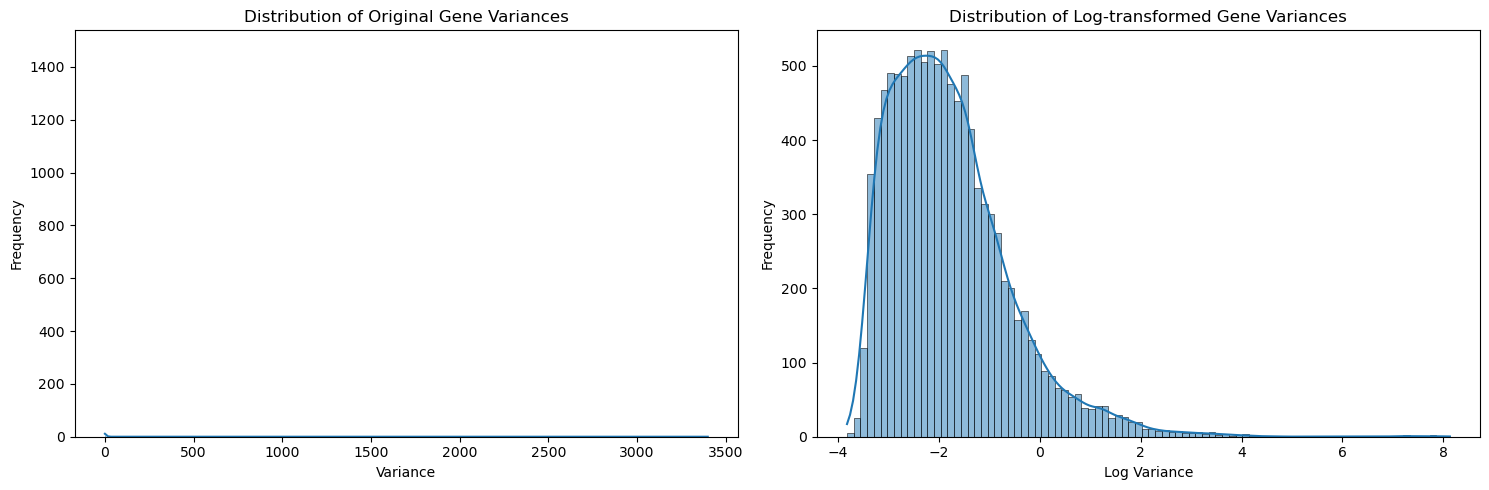

Original Variances:
Min: 0.02181428298354149
Max: 3398.626953125
Mean: 1.824905514717102
Median: 0.1388520896434784

Log-transformed Variances:
Min: -3.8251898288726807
Max: 8.131126403808594
Mean: -1.7895039319992065
Median: -1.9743459224700928

Invalid Values:
NaNs in original: 0
Infs in original: 0
NaNs in log-transformed: 0
Infs in log-transformed: 0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

adata = sc.read("/Users/chen_yiru/Desktop/simulation/Sample_data_151676.h5ad")

# 计算每个基因的方差（适用于稀疏矩阵）
def sparse_var(X, axis=0):
    mean = np.array(X.mean(axis=axis)).flatten()
    squared_diff = X.copy()
    squared_diff.data **= 2
    var = squared_diff.mean(axis=axis).A1 - mean**2
    return var

gene_variances = sparse_var(adata.X)

# 创建一个新的图形，包含两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 绘制原始方差的分布
sns.histplot(gene_variances, ax=ax1, kde=True)
ax1.set_title('Distribution of Original Gene Variances')
ax1.set_xlabel('Variance')
ax1.set_ylabel('Frequency')

# 对数变换方差
log_gene_variances = np.log(gene_variances + 1e-8)  # 添加小常数以避免log(0)

# 绘制对数变换后方差的分布
sns.histplot(log_gene_variances, ax=ax2, kde=True)
ax2.set_title('Distribution of Log-transformed Gene Variances')
ax2.set_xlabel('Log Variance')
ax2.set_ylabel('Frequency')

# 调整布局并显示图形
plt.tight_layout()
plt.show()

# 打印一些基本统计信息
print("Original Variances:")
print(f"Min: {gene_variances.min()}")
print(f"Max: {gene_variances.max()}")
print(f"Mean: {gene_variances.mean()}")
print(f"Median: {np.median(gene_variances)}")

print("\nLog-transformed Variances:")
print(f"Min: {log_gene_variances.min()}")
print(f"Max: {log_gene_variances.max()}")
print(f"Mean: {log_gene_variances.mean()}")
print(f"Median: {np.median(log_gene_variances)}")

# 检查是否有无效值
print("\nInvalid Values:")
print(f"NaNs in original: {np.isnan(gene_variances).sum()}")
print(f"Infs in original: {np.isinf(gene_variances).sum()}")
print(f"NaNs in log-transformed: {np.isnan(log_gene_variances).sum()}")
print(f"Infs in log-transformed: {np.isinf(log_gene_variances).sum()}")

Original - Mean: 1.256456, Std: 35.588600
Generated - Mean: 1.212851, Std: 31.497923

Quantiles comparison:
1.0% - Original: 0.023836, Generated: 0.012176, Diff: 0.011660
5.0% - Original: 0.029037, Generated: 0.017135, Diff: 0.011902
10.0% - Original: 0.033781, Generated: 0.024155, Diff: 0.009627
25.0% - Original: 0.051924, Generated: 0.048533, Diff: 0.003391
50.0% - Original: 0.101791, Generated: 0.109404, Diff: 0.007613
75.0% - Original: 0.220759, Generated: 0.246967, Diff: 0.026207
90.0% - Original: 0.536507, Generated: 0.526866, Diff: 0.009641
95.0% - Original: 1.097161, Generated: 0.897938, Diff: 0.199223
99.0% - Original: 5.321732, Generated: 5.915461, Diff: 0.593729
99.5% - Original: 10.816392, Generated: 11.218422, Diff: 0.402030
99.9% - Original: 98.907086, Generated: 174.070999, Diff: 75.163913

Overall Correlation: 0.981699


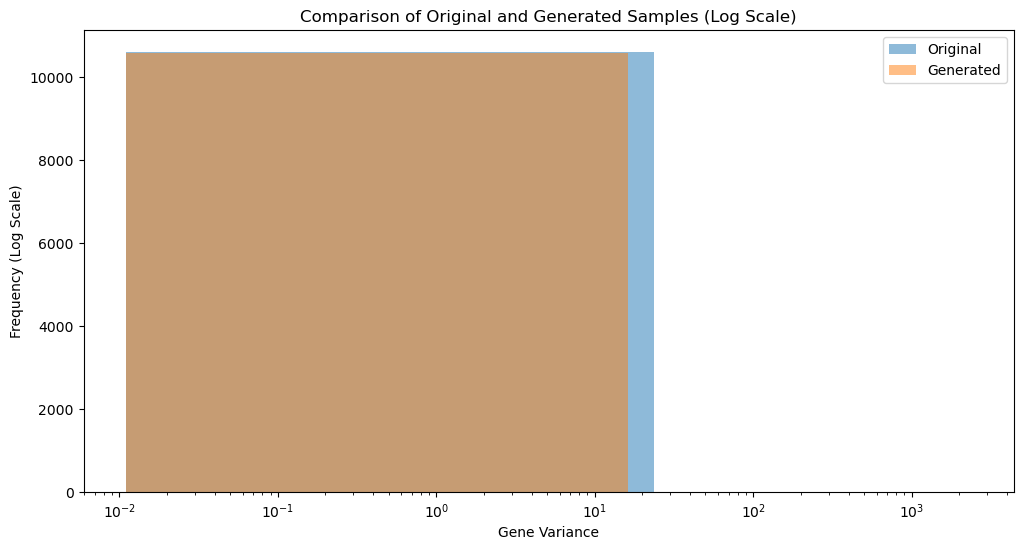

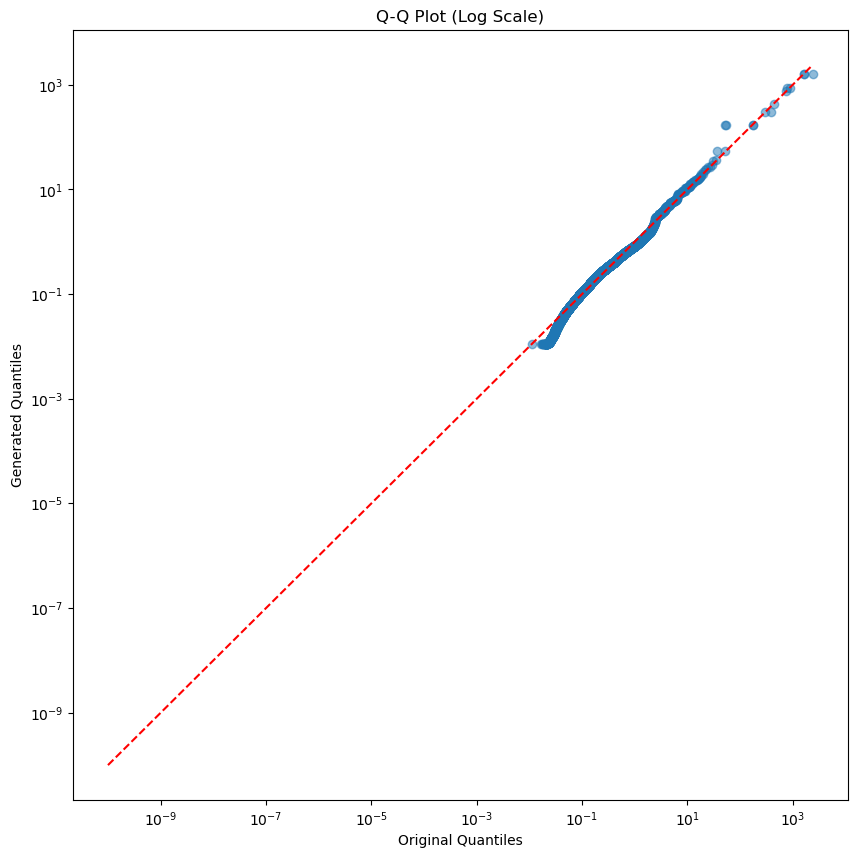

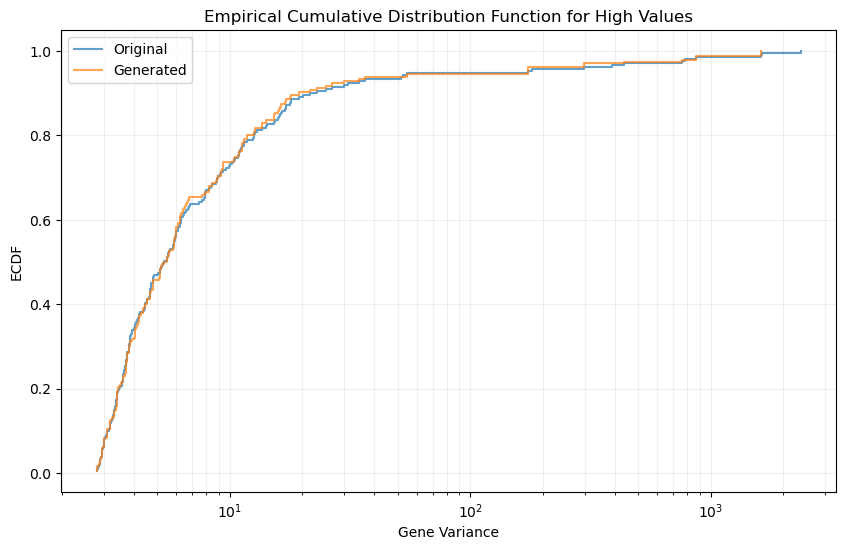


High values statistics:
Original - Count: 213, Mean: 52.467129, Max: 2381.066406
Generated - Count: 240, Mean: 45.235484, Max: 1627.315918


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151675.h5ad")

if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算每个基因的方差（适用于普通numpy数组）
def calc_var(X, axis=0):
    # 直接使用numpy的var函数
    return np.var(X, axis=axis)

gene_variances = calc_var(adata.X)

# 设定阈值，例如使用98百分位数
threshold = np.percentile(gene_variances, 98)

# 分割数据
main_data = gene_variances[gene_variances <= threshold]
tail_data = gene_variances[gene_variances > threshold]

# 对主体部分拟合广义帕累托分布
shape, loc, scale = genpareto.fit(main_data)

# 生成新样本
n_main = len(main_data)
n_tail = len(tail_data)

# 对主体部分使用拟合的分布生成样本
new_main = genpareto.rvs(shape, loc, scale, size=n_main)

# 对尾部直接进行重抽样
new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

# 合并样本
new_samples = np.concatenate([new_main, new_tail])

# 确保新样本在原始数据的范围内
new_samples = np.clip(new_samples, np.min(gene_variances), np.max(gene_variances))

# 计算统计量
print(f"Original - Mean: {np.mean(gene_variances):.6f}, Std: {np.std(gene_variances):.6f}")
print(f"Generated - Mean: {np.mean(new_samples):.6f}, Std: {np.std(new_samples):.6f}")

# 计算分位数
quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]
original_quantiles = np.quantile(gene_variances, quantiles)
generated_quantiles = np.quantile(new_samples, quantiles)

print("\nQuantiles comparison:")
for q, orig, gen in zip(quantiles, original_quantiles, generated_quantiles):
    print(f"{q*100}% - Original: {orig:.6f}, Generated: {gen:.6f}, Diff: {abs(orig-gen):.6f}")

# 计算相关性
correlation = np.corrcoef(np.sort(gene_variances), np.sort(new_samples))[0, 1]
print(f"\nOverall Correlation: {correlation:.6f}")

# 可视化（使用对数刻度）
plt.figure(figsize=(12, 6))
plt.hist(gene_variances, bins=100, alpha=0.5, label='Original')
plt.hist(new_samples, bins=100, alpha=0.5, label='Generated')
plt.legend()
plt.title('Comparison of Original and Generated Samples (Log Scale)')
plt.xlabel('Gene Variance')
plt.ylabel('Frequency (Log Scale)')
plt.xscale('log')
plt.show()

# QQ图（使用对数刻度）
plt.figure(figsize=(10, 10))
plt.scatter(np.sort(gene_variances), np.sort(new_samples), alpha=0.5)
plt.plot([1e-10, max(max(gene_variances), max(new_samples))], [1e-10, max(max(gene_variances), max(new_samples))], 'r--')
plt.xlabel('Original Quantiles')
plt.ylabel('Generated Quantiles')
plt.title('Q-Q Plot (Log Scale)')
plt.xscale('log')
plt.yscale('log')
plt.show()

# 高值区域的比较（使用经验累积分布函数）
plt.figure(figsize=(10, 6))
original_high = gene_variances[gene_variances > threshold]
generated_high = new_samples[new_samples > threshold]

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

x_orig, y_orig = ecdf(original_high)
x_gen, y_gen = ecdf(generated_high)

plt.step(x_orig, y_orig, where='post', label='Original', alpha=0.7)
plt.step(x_gen, y_gen, where='post', label='Generated', alpha=0.7)
plt.xlabel('Gene Variance')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function for High Values')
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# 打印高值区域的统计信息
print("\nHigh values statistics:")
print(f"Original - Count: {len(original_high)}, Mean: {np.mean(original_high):.6f}, Max: {np.max(original_high):.6f}")
print(f"Generated - Count: {len(generated_high)}, Mean: {np.mean(generated_high):.6f}, Max: {np.max(generated_high):.6f}")


Alternative Evaluation Metrics:
Cohen's d: 0.0013
Relative Error: 0.0347
KS Statistic: 0.0916

Quantile Relative Errors:
25.0th percentile: 0.0653
50.0th percentile: 0.0748
75.0th percentile: 0.1187
90.0th percentile: 0.0180
95.0th percentile: 0.1816
99.0th percentile: 0.1116


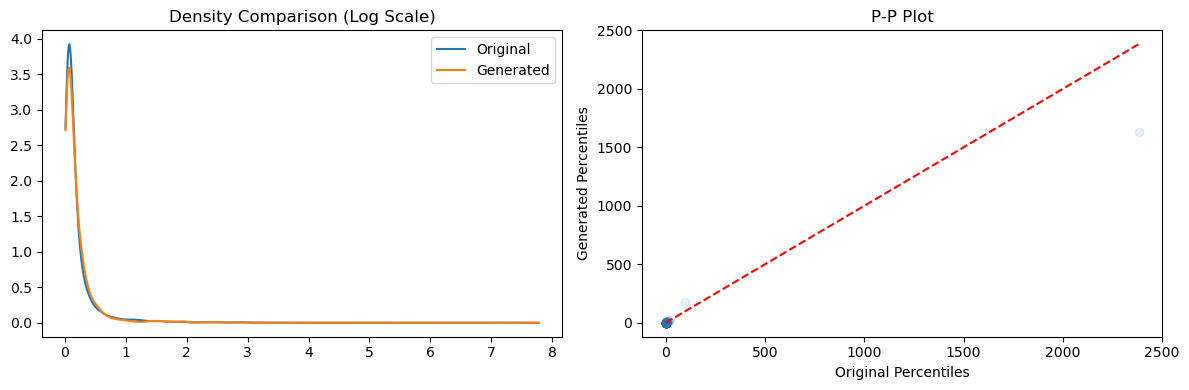

In [6]:
# 1. 效应量计算 (Cohen's d)
def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(x1) - np.mean(x2)) / pooled_se

# 2. 相对误差
def relative_error(original, generated):
    return np.abs(np.mean(original) - np.mean(generated)) / np.mean(original)

# 3. KS统计量（不考虑p值）
from scipy.stats import ks_2samp

# 计算这些指标
effect_size = cohens_d(gene_variances, new_samples)
rel_error = relative_error(gene_variances, new_samples)
ks_stat, _ = ks_2samp(gene_variances, new_samples)

print("\nAlternative Evaluation Metrics:")
print(f"Cohen's d: {effect_size:.4f}")
print(f"Relative Error: {rel_error:.4f}")
print(f"KS Statistic: {ks_stat:.4f}")

# 4. 实际应用意义的评估
# 比较关键分位数的相对误差
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
orig_quant = np.quantile(gene_variances, quantiles)
gen_quant = np.quantile(new_samples, quantiles)
rel_errors = np.abs(orig_quant - gen_quant) / orig_quant

print("\nQuantile Relative Errors:")
for q, err in zip(quantiles, rel_errors):
    print(f"{q*100}th percentile: {err:.4f}")

# 5. 可视化评估
plt.figure(figsize=(12, 4))

# 密度图比较
plt.subplot(121)
from scipy.stats import gaussian_kde
kde_orig = gaussian_kde(np.log1p(gene_variances))
kde_gen = gaussian_kde(np.log1p(new_samples))
x_range = np.linspace(np.min(np.log1p(gene_variances)), 
                      np.max(np.log1p(gene_variances)), 1000)
plt.plot(x_range, kde_orig(x_range), label='Original')
plt.plot(x_range, kde_gen(x_range), label='Generated')
plt.title('Density Comparison (Log Scale)')
plt.legend()

# PP图
plt.subplot(122)
percentiles = np.linspace(0, 100, 1000)
orig_perc = np.percentile(gene_variances, percentiles)
gen_perc = np.percentile(new_samples, percentiles)
plt.scatter(orig_perc, gen_perc, alpha=0.1)
plt.plot([min(orig_perc), max(orig_perc)], 
         [min(orig_perc), max(orig_perc)], 'r--')
plt.title('P-P Plot')
plt.xlabel('Original Percentiles')
plt.ylabel('Generated Percentiles')

plt.tight_layout()
plt.show()

In [7]:
from scipy.stats import kstest

# 对主体部分数据进行 K-S 检验
main_data = gene_variances[gene_variances <= threshold]
ks_statistic, p_value = kstest(main_data, 'genpareto', args=(shape, loc, scale))

print(f"Kolmogorov-Smirnov Test for Main Data:")
print(f"Test Statistic: {ks_statistic:.6f}")
print(f"p-value: {p_value:.6f}")

if p_value >= 0.05:
    print("Cannot reject the null hypothesis that the data follows the Generalized Pareto distribution.")
else:
    print("Reject the null hypothesis that the data follows the Generalized Pareto distribution.")

Kolmogorov-Smirnov Test for Main Data:
Test Statistic: 0.057601
p-value: 0.000000
Reject the null hypothesis that the data follows the Generalized Pareto distribution.


In [3]:
import numpy as np
import pandas as pd
import anndata
import scipy.sparse as sp
from scipy.spatial.distance import cdist
import scanpy as sc
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy import stats, optimize
from scipy import special

class variation_sim:
    def __init__(self, max_components=10, max_iter=1000, tol=1e-4):
        self.max_components = max_components
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = None
        self.beta = None
        self.pi = None

    def fit(self, sehat, df, betahat=None, unimodal='auto', singlecomp=False):
        self.sehat = np.maximum(sehat, 1e-8)  # 避免零值
        self.df = df
        self.betahat = betahat
        self.unimodal = unimodal
        self.singlecomp = singlecomp
        if singlecomp:
            self._fit_single_component()
        else:
            self._fit_multiple_components()
        return self

    def _fit_single_component(self):
        log_s2 = np.log(self.sehat**2)
        m1 = np.mean(log_s2)
        m2 = np.mean((log_s2 - m1)**2)
        alpha_init = max((2 * m2) / (m2 - special.polygamma(1, self.df/2)), 1.1)
        beta_init = np.exp(m1 + np.log(self.df/2) - special.digamma(self.df/2)) * (alpha_init - 1)

        def obj(params):
            alpha, beta = params
            return -np.sum(stats.invgamma.logpdf(self.sehat**2, alpha, scale=beta))

        res = optimize.minimize(obj, [alpha_init, beta_init], method='L-BFGS-B', bounds=[(1.1, None), (1e-5, None)])
        self.alpha = np.array([res.x[0]])
        self.beta = np.array([res.x[1]])
        self.pi = np.array([1.0])

    def _fit_multiple_components(self):
        best_bic = np.inf
        best_model = None
        for n_components in range(1, self.max_components + 1):
            try:
                model = self._fit_model(n_components)
                bic = self._compute_bic(model)
                if bic < best_bic:
                    best_bic = bic
                    best_model = model
                else:
                    break
            except Exception as e:
                print(f"Error fitting {n_components} components: {str(e)}")
                continue
        
        if best_model is None:
            print("Warning: Failed to fit any model. Using single component as fallback.")
            self._fit_single_component()
        else:
            self.alpha, self.beta, self.pi = best_model

    def _fit_model(self, n_components):
        alpha = np.linspace(1.1, 10, n_components)
        beta = np.ones(n_components)
        pi = np.ones(n_components) / n_components
        for _ in range(self.max_iter):
            old_params = np.concatenate([alpha, beta, pi])
            resp = self._e_step(alpha, beta, pi)
            alpha, beta, pi = self._m_step(resp, alpha, beta)
            if self.unimodal in ['variance', 'auto']:
                alpha, beta = self._apply_unimodal_constraint(alpha, beta, 'variance')
            if self.unimodal in ['precision', 'auto']:
                alpha, beta = self._apply_unimodal_constraint(alpha, beta, 'precision')
            new_params = np.concatenate([alpha, beta, pi])
            if np.max(np.abs(new_params - old_params)) < self.tol:
                break
        return alpha, beta, pi

    def _e_step(self, alpha, beta, pi):
        n = len(self.sehat)
        k = len(alpha)
        resp = np.zeros((n, k))
        for j in range(k):
            resp[:, j] = pi[j] * stats.invgamma.pdf(self.sehat**2, alpha[j], scale=beta[j])
        row_sums = resp.sum(axis=1, keepdims=True)
        resp = np.divide(resp, row_sums, where=row_sums!=0)
        return resp

    def _m_step(self, resp, alpha, beta):
        n = len(self.sehat)
        k = resp.shape[1]
        pi = resp.sum(axis=0) / n
        new_alpha = np.zeros(k)
        new_beta = np.zeros(k)
        for j in range(k):
            def obj(params):
                a, b = params
                return -np.sum(resp[:, j] * stats.invgamma.logpdf(self.sehat**2, a, scale=b))

            res = optimize.minimize(obj, [alpha[j], beta[j]], method='L-BFGS-B', bounds=[(1.1, None), (1e-5, None)])
            new_alpha[j], new_beta[j] = res.x
        return new_alpha, new_beta, pi

    def _apply_unimodal_constraint(self, alpha, beta, mode):
        if mode == 'variance':
            c = beta / (alpha + 1)
            order = np.argsort(c)
            alpha = alpha[order]
            beta = c[order] * (alpha + 1)
        elif mode == 'precision':
            c = np.where(alpha > 1, beta / (alpha - 1), np.inf)
            order = np.argsort(c)[::-1]
            alpha = alpha[order]
            beta = np.where(alpha > 1, c[order] * (alpha - 1), beta[order])
        return alpha, beta

    def _compute_bic(self, model):
        alpha, beta, pi = model
        n = len(self.sehat)
        k = len(alpha)
        log_likelihood = np.sum(np.log(np.sum([pi[j] * stats.invgamma.pdf(self.sehat**2, alpha[j], scale=beta[j]) for j in range(k)], axis=0)))
        num_params = 3 * k - 1
        return -2 * log_likelihood + num_params * np.log(n)

    def posterior_mean(self):
        resp = self._e_step(self.alpha, self.beta, self.pi)
        return np.sum(resp * (self.beta / (self.alpha - 1))[np.newaxis, :], axis=1)

    def moderated_t_test(self):
        if self.betahat is None:
            raise ValueError("betahat is required for moderated t-test")
        post_var = self.posterior_mean()
        t_stat = self.betahat / np.sqrt(post_var)
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=self.df))
        return p_values

/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/3v/3zvgxtgj0c18q0snf15v3prc0000gn/T/ipykernel_23322/39031610.py:112: RuntimeWarning: divide by zero encountered in divide
  accept_prob = densities / max_density


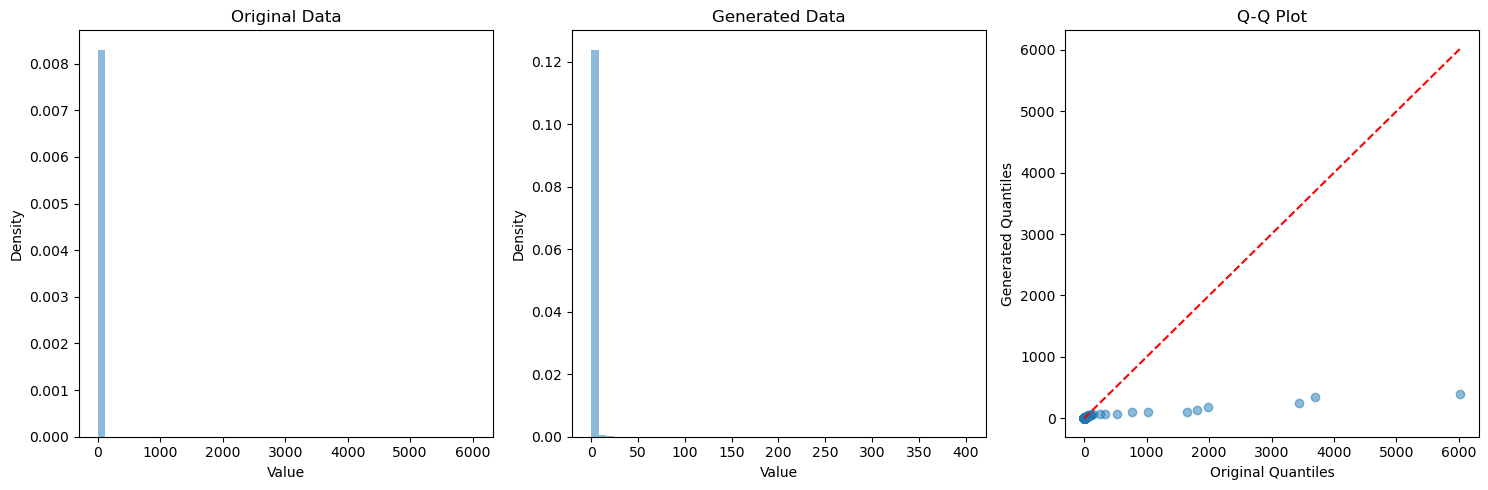

Original - Mean: 1.732972, Std: 66.771843
Generated - Mean: 0.487828, Std: 5.453958

Quantiles comparison:
1.0% - Original: 0.002807, Generated: 0.002101, Diff: 0.000706
5.0% - Original: 0.004204, Generated: 0.005213, Diff: 0.001009
10.0% - Original: 0.006432, Generated: 0.008350, Diff: 0.001918
25.0% - Original: 0.019064, Generated: 0.019734, Diff: 0.000670
50.0% - Original: 0.075172, Generated: 0.057990, Diff: 0.017182
75.0% - Original: 0.224860, Generated: 0.285941, Diff: 0.061080
90.0% - Original: 0.590135, Generated: 0.668409, Diff: 0.078273
95.0% - Original: 1.190503, Generated: 1.254722, Diff: 0.064219
99.0% - Original: 6.345970, Generated: 5.421411, Diff: 0.924560


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto, lognorm
from scipy.optimize import minimize
import scanpy as sc

def calc_var(X, axis=0):
    return np.var(X, axis=axis)

def find_threshold_likelihood(data, start_percentile=80, end_percentile=95):
    """使用较高的百分位数范围来寻找帕累托分布的起始点"""
    percentiles = np.arange(start_percentile, end_percentile)
    thresholds = np.percentile(data, percentiles)
    max_likelihood = -np.inf
    optimal_threshold = None
    optimal_params = None
    
    for threshold in thresholds:
        main_data = data[data <= threshold]
        tail_data = data[data > threshold]
        
        if len(main_data) < 10 or len(tail_data) < 10:
            continue
            
        # 计算对数正态分布的对数似然
        log_main = np.log(main_data)
        mu = np.mean(log_main)
        sigma = np.std(log_main)
        lognorm_ll = np.sum(lognorm.logpdf(main_data, s=sigma, scale=np.exp(mu)))
        
        # 计算帕累托分布的对数似然
        try:
            shape, loc, scale = genpareto.fit(tail_data)
            pareto_ll = np.sum(genpareto.logpdf(tail_data, shape, loc=loc, scale=scale))
            
            # 添加平滑过渡的惩罚项
            density_diff = abs(
                lognorm.pdf(threshold, s=sigma, scale=np.exp(mu)) - 
                genpareto.pdf(threshold, shape, loc=loc, scale=scale)
            )
            transition_penalty = -density_diff * 100  # 惩罚因子可以调整
            
            total_ll = lognorm_ll + pareto_ll + transition_penalty
            
            if total_ll > max_likelihood:
                max_likelihood = total_ll
                optimal_threshold = threshold
                optimal_params = {
                    'lognorm': (sigma, 0, np.exp(mu)),
                    'pareto': (shape, loc, scale)
                }
                
        except:
            continue
    
    if optimal_threshold is None:
        optimal_threshold = np.percentile(data, 90)
        
    return optimal_threshold, optimal_params

def fit_mixed_distribution(data):
    # 使用似然比方法找到最优分割点
    threshold, optimal_params = find_threshold_likelihood(data)
    
    main_data = data[data <= threshold]
    tail_data = data[data > threshold]
    
    # 使用最优参数
    if optimal_params is not None:
        sigma, loc, scale = optimal_params['lognorm']
        shape, loc_p, scale_p = optimal_params['pareto']
    else:
        # 如果没有找到最优参数，重新拟合
        log_data = np.log(main_data)
        mu = np.mean(log_data)
        sigma = np.std(log_data)
        shape, loc_p, scale_p = genpareto.fit(tail_data)
        scale = np.exp(mu)
        loc = 0
    
    # 计算混合权重
    weight_lognorm = len(main_data) / len(data)
    weight_pareto = len(tail_data) / len(data)
    
    return {
        'lognorm_params': (sigma, loc, scale),
        'pareto_params': (shape, loc_p, scale_p),
        'weights': (weight_lognorm, weight_pareto),
        'threshold': threshold
    }

def generate_mixed_samples(params, n_samples):
    weight_lognorm, weight_pareto = params['weights']
    n_lognorm = int(n_samples * weight_lognorm)
    n_pareto = n_samples - n_lognorm
    
    # 生成对数正态分布样本
    sigma, loc, scale = params['lognorm_params']
    lognorm_samples = lognorm.rvs(s=sigma, loc=loc, scale=scale, size=n_lognorm)
    
    # 生成帕累托分布样本，并进行截断
    shape, loc, scale = params['pareto_params']
    threshold = params['threshold']
    
    # 使用接受-拒绝采样来生成截断的帕累托样本
    pareto_samples = []
    max_density = genpareto.pdf(threshold, shape, loc=loc, scale=scale)
    
    while len(pareto_samples) < n_pareto:
        candidates = genpareto.rvs(shape, loc=loc, scale=scale, size=n_pareto)
        densities = genpareto.pdf(candidates, shape, loc=loc, scale=scale)
        accept_prob = densities / max_density
        accept = np.random.random(n_pareto) < accept_prob
        
        valid_samples = candidates[accept]
        pareto_samples.extend(valid_samples[:n_pareto - len(pareto_samples)])
    
    pareto_samples = np.array(pareto_samples[:n_pareto])
    
    # 合并样本并确保所有值都是正的
    mixed_samples = np.concatenate([lognorm_samples, pareto_samples])
    mixed_samples = np.maximum(mixed_samples, 0)
    np.random.shuffle(mixed_samples)
    
    return mixed_samples

def plot_distribution_components(data, params):
    """可视化混合分布的组件"""
    plt.figure(figsize=(12, 6))
    
    # 绘制原始数据直方图
    plt.hist(data, bins=50, density=True, alpha=0.5, label='Original Data')
    
    # 生成用于绘制的x值
    x = np.linspace(min(data), max(data), 1000)
    
    # 绘制对数正态分布组件
    sigma, loc, scale = params['lognorm_params']
    weight_lognorm = params['weights'][0]
    y_lognorm = weight_lognorm * lognorm.pdf(x, s=sigma, scale=scale)
    plt.plot(x, y_lognorm, 'r-', label='Log-normal Component')
    
    # 绘制帕累托分布组件
    shape, loc, scale = params['pareto_params']
    weight_pareto = params['weights'][1]
    y_pareto = weight_pareto * genpareto.pdf(x, shape, loc=loc, scale=scale)
    plt.plot(x, y_pareto, 'g-', label='Pareto Component')
    
    # 绘制混合分布
    plt.plot(x, y_lognorm + y_pareto, 'k--', label='Mixed Distribution')
    
    plt.axvline(params['threshold'], color='gray', linestyle=':', label='Threshold')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution Components')
    plt.legend()
    plt.show()


def analyze_and_simulate(data):
    # 拟合混合分布
    params = fit_mixed_distribution(data)
    
    # 生成新样本
    new_samples = generate_mixed_samples(params, len(data))
    
    # 可视化比较
    plt.figure(figsize=(15, 5))
    
    # 原始数据直方图
    plt.subplot(131)
    plt.hist(data, bins=50, density=True, alpha=0.5, label='Original')
    plt.title('Original Data')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # 生成数据直方图
    plt.subplot(132)
    plt.hist(new_samples, bins=50, density=True, alpha=0.5, label='Generated')
    plt.title('Generated Data')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # QQ图
    plt.subplot(133)
    plt.scatter(np.sort(data), np.sort(new_samples), alpha=0.5)
    plt.plot([data.min(), data.max()], [data.min(), data.max()], 'r--')
    plt.title('Q-Q Plot')
    plt.xlabel('Original Quantiles')
    plt.ylabel('Generated Quantiles')
    
    plt.tight_layout()
    plt.show()
    
    # 计算统计量
    print(f"Original - Mean: {np.mean(data):.6f}, Std: {np.std(data):.6f}")
    print(f"Generated - Mean: {np.mean(new_samples):.6f}, Std: {np.std(new_samples):.6f}")
    
    # 计算分位数
    quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    orig_quantiles = np.quantile(data, quantiles)
    gen_quantiles = np.quantile(new_samples, quantiles)
    
    print("\nQuantiles comparison:")
    for q, orig, gen in zip(quantiles, orig_quantiles, gen_quantiles):
        print(f"{q*100}% - Original: {orig:.6f}, Generated: {gen:.6f}, Diff: {abs(orig-gen):.6f}")
    
    return new_samples

# 主程序
if __name__ == "__main__":
    # 读取数据
    adata = sc.read("/Users/chen_yiru/Desktop/simulation/processed_151673_filtered.h5ad")
    # 如果adata.X是稀疏矩阵，请转换为密集矩阵
    if sp.issparse(adata.X):
        adata.X = adata.X.A
    # 计算基因方差
    gene_variances = calc_var(adata.X)
    
    # 分析和模拟
    new_samples = analyze_and_simulate(gene_variances)